---

# Modelling R&D

By: Tomás Urdiales

-> Notebook for modelling experiments.

##### Libraries

In [8]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error

from src import utils
from src.cross_validation import backtesting_CV
from src.join_qh_min_data import join_qh_min_data

##### Parameters

In [2]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [3]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]
temp = utils.load_temp_historical_data().loc["2021":"2022"]

# Additional features:
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()
# Add in XB data:
qh = qh.assign(xb_day_ahead = xb["xb_day_ahead"])
qh = qh.assign(xb_intraday = xb["xb_intraday"])
qh = qh.assign(xb_grand_total = xb["xb_grand_total"])
qh = qh.assign(xb_physical_accounting_net_import_mw = xb["xb_physical_accounting_net_import_mw"])
# Add in temperature data:
qh = qh.assign(temperature = temp["temperature"])
# Create temperature gradient with respect to one hour ahead:
qh = qh.assign(temperature_diff = -temp["temperature"].diff(-4))

In [4]:
def check(a,b):
    print(f"{(1-a/111.98)*100 :.1f}% | {(1-b/148.97)*100 :.1f}% | {a/145.55 :.3f}")

In [5]:
model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

---

## Legacy model benchmark

In [8]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -3]},
    "net_regulation_volume": {
        "lags": [-2, -3]},
}

# Prepare training dataframe:d
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 8, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False
                                )

check(111.98, 148.97)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 8 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:11<00:00,  7.77it/s]



Train set average error:
MAE: 110.69MW | RMSE: 147.18MW
Test set average error:
MAE: 111.98MW | RMSE: 148.97MW | MASE: 0.7470 | P90 Error: 236.77MW | Max Error: 1151.7 (2022-09-06 21:15:00+02:00)
Time elapsed: 11.78s | Time per split: ~0.13s

0.0% | 0.0% | 0.769


---

## Naive estimator

In [35]:
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [36]:
TARGET = "system_imbalance_cum15_from_qh_plus_1"

lag = 2
if MINUTE == "all":
    lag = 15 * lag

total_mae = mean_absolute_error(df[TARGET].loc["2022"][lag:], df[TARGET].loc["2022"].shift(lag)[lag:])
total_rmse = mean_squared_error(df[TARGET].loc["2022"][lag:], df[TARGET].loc["2022"].shift(lag)[lag:], squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(149.88, 195.53)

Total MAE: 149.88MW | Total RMSE: 195.53MW
-33.8% | -31.3% | 1.030


In [39]:
TARGET = "system_imbalance_cum15_from_qh_plus_1"

total_mae = mean_absolute_error(df[TARGET].loc["2022"], df["system_imbalance_from_minute_minus_2"].loc["2022"])
total_rmse = mean_squared_error(df[TARGET].loc["2022"], df["system_imbalance_from_minute_minus_2"].loc["2022"], squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(145.55, 191.93)

Total MAE: 145.55MW | Total RMSE: 191.93MW
-30.0% | -28.8% | 1.000


---

## CV (XB set)

In [35]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4,
    max_train_size=15 * 4 * 24 * 7 * 30,
    test_size=15 * 4 * 24 * 4,
    gap=0
)

In [37]:
from sklearn.linear_model import Ridge

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)
check(102.50, 135.92)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:37<00:00,  2.42it/s]



Train set average error:
MAE: 98.72MW | RMSE: 130.83MW
Test set average error:
MAE: 102.50MW | RMSE: 135.92MW | MASE: 0.6841 | P90 Error: 216.38MW | Max Error: 1138.0 (2022-10-05 10:00:00+02:00)
Time elapsed: 37.79s | Time per split: ~0.42s

8.5% | 8.8% | 0.704


## Encoding dummy variables

In [11]:
# Let's encode the minute of qh with dummy variables:
df = df.assign(minute_of_qh=(df.index.minute % 15).astype("category"))
df = pd.get_dummies(df,
    columns=["minute_of_qh"],
    drop_first=True,
    prefix="min", prefix_sep="_")

In [24]:
from sklearn.neural_network import MLPRegressor

tscv = TimeSeriesSplit(
    n_splits=52 // 2 // 2, max_train_size=15 * 4 * 24 * 7 * 70, test_size=15 * 4 * 24 * 7 * 4, gap=0
)

model_mlp = MLPRegressor(
    hidden_layer_sizes=[12, 12],
    alpha=0.15,
    tol=1e-3,
    shuffle=True,
    activation="relu",
    solver="lbfgs",
    max_iter=400,
    early_stopping=True,
    n_iter_no_change=5,
    momentum=True,
    verbose=False,
)

# Cross-validation:
results_mlp = backtesting_CV(
    model=model_mlp,
    data=df,
    time_splits=tscv,
    use_scaler=True,
    features=FEATURES,
    target=TARGET,
    progress_bar=True,
    verbose=False,
)

check(100.75, 133.45)

---

## qh-minute errors

In [8]:
def show_error_per_minute(df):
    df = df.copy().assign(minute_of_qh=(df.index.minute % 15).astype("category"))
    metrics_per_minute = np.array([]).reshape(0,3)

    for minute in (df.index.minute % 15).unique():
        df_minute = df.loc[df["minute_of_qh"] == minute]
        total_mae = mean_absolute_error(df_minute["y_pred"], df_minute["y_test"])
        total_rmse = mean_squared_error(df_minute["y_pred"], df_minute["y_test"], squared=False)

        metrics_per_minute = np.vstack([metrics_per_minute, np.array([minute, total_mae, total_rmse])])
    
    # Turn into a dataframe:
    metrics_per_minute = pd.DataFrame(metrics_per_minute, columns=["minute_of_qh", "MAE", "RMSE"]) \
        .set_index("minute_of_qh").sort_index()

    # And plot:
    metrics_per_minute.plot(kind="bar")
    plt.ylim(0, 155)
    plt.xlabel("Minute of qh"); plt.ylabel("Error [MW]")
    plt.xticks(range(15), labels=[str(ii) for ii in range(15)], rotation=0)
    # plt.grid()
    plt.show()
    return metrics_per_minute

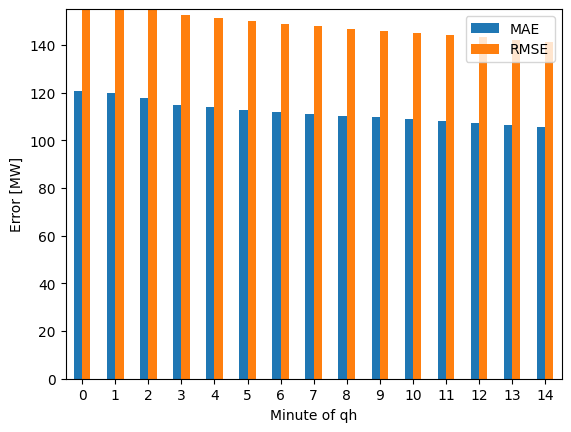

,MAE,RMSE
minute_of_qh,,
0.0,120.590721,159.665970
1.0,119.904076,158.845764
2.0,117.674217,156.116074
3.0,114.928085,152.488953
4.0,113.844009,151.067993
5.0,112.867760,149.877136
6.0,111.962463,148.752136
7.0,111.170074,147.784546
8.0,110.356140,146.791885


In [9]:
show_error_per_minute(results_linear[0])

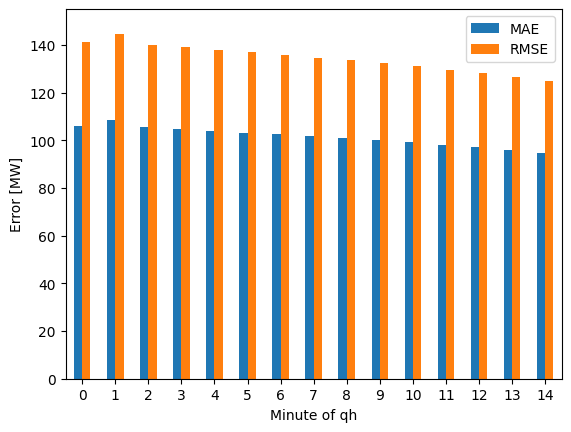

,MAE,RMSE
minute_of_qh,,
0.0,106.137192,141.060532
1.0,108.382637,144.403214
2.0,105.419220,140.108643
3.0,104.728371,139.033112
4.0,103.982903,137.961655
5.0,103.227036,136.904419
6.0,102.455048,135.786713
7.0,101.707588,134.706482
8.0,100.861298,133.469452


In [17]:
show_error_per_minute(results_linear15)

---

## R&D

In [81]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

#### Linear

In [7]:
# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4,
    max_train_size=15 * 4 * 24 * 7 * 20,
    test_size=15 * 4 * 24 * 4,
    gap=0
)

from sklearn.linear_model import Ridge

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

scaler_robust = RobustScaler(
    with_centering=True,
    with_scaling=True,
)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=scaler_robust,
                                verbose=False)

MODEL: Ridge
Using RobustScaler
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



  0%|          | 0/91 [00:00<?, ?it/s]

100%|██████████| 91/91 [00:34<00:00,  2.62it/s]


Train set average error:
MAE: 99.79MW | RMSE: 132.16MW
Test set average error:
MAE: 102.55MW | RMSE: 135.98MW | MASE: 0.6845 | P90 Error: 216.27MW | Max Error: 1158.2 (2022-10-05 10:00:00+02:00)
Time elapsed: 34.87s | Time per split: ~0.38s



In [12]:
from sklearn.linear_model import HuberRegressor

tscv = TimeSeriesSplit(
    n_splits=52 // 2, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 7 * 2, gap=0
)

model_huber = HuberRegressor(
    epsilon=1.2,
    max_iter=500,
    alpha=0,
    tol=1e-3,
)

# Cross-validation:
results_huber = backtesting_CV(
    model=model_huber,
    data=df,
    time_splits=tscv,
    features=FEATURES,
    target=TARGET,
    use_scaler=True,
    progress_bar=True,
    verbose=False
)

check(102.83, 136.27)

MODEL: HuberRegressor
Time configuration: 26 splits, 14 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 26/26 [09:08<00:00, 21.11s/it]


Train set average error:
MAE: 99.50MW | RMSE: 132.03MW
Test set average error:
MAE: 102.83MW | RMSE: 136.27MW | MASE: 0.6860 | P90 Error: 217.32MW | Max Error: 1138.9 (2022-10-05 10:00:00+02:00)
Time elapsed: 548.95s | Time per split: ~21.11s

6.18% | 6.03%


In [84]:
from sklearn.svm import LinearSVR

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52,
    max_train_size=15 * 4 * 24 * 7 * 30,
    test_size=15 * 4 * 24 * 7,
    gap=0
)

svr = LinearSVR(
    tol=1e-3,
    C=25,
    epsilon=0.1,
    fit_intercept=True,
    max_iter=500,
    dual="auto"
)

# Cross-validation:
results_svr = backtesting_CV(
    model=svr,
    data=df, 
    time_splits=tscv,
    features=FEATURES,
    use_scaler=True,
    target=TARGET,
    progress_bar=True,
    verbose=False
)

check(102.82, 136.27)

MODEL: LinearSVR
Time configuration: 52 splits, 7 testing days, 30 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [12:58<00:00, 14.97s/it]


Train set average error:
MAE: 98.48MW | RMSE: 131.08MW
Test set average error:
MAE: 102.34MW | RMSE: 136.05MW | MASE: 0.6831 | P90 Error: 216.28MW | Max Error: 1143.7 (2022-10-05 10:00:00+02:00)
Time elapsed: 778.54s | Time per split: ~14.97s

8.2% | 8.5% | 0.706


#### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model_pca = make_pipeline(StandardScaler(), PCA(20), LinearRegression())

# Cross-validation:
results_pca = backtesting_CV(
    model=model_pca,
    data=df,
    time_splits=tscv,
    features=FEATURES,
    target=TARGET,
    use_scaler=False,
    progress_bar=True,
    verbose=False)

#### SVR

In [120]:
from sklearn.svm import SVR

svr = SVR(
    kernel="rbf",
    gamma="scale",
    C=20,
    epsilon=0.1,
    cache_size=1000,  # [MB]
)

# Cross-validation:
results_svr = backtesting_CV(model=svr,
                             data=df,
                             time_splits=tscv,
                             features=FEATURES,
                             use_scaler=True,
                             target=TARGET,
                             progress_bar=True,
                             verbose=False)

#### SGD

In [82]:
from sklearn.linear_model import SGDRegressor

tscv = TimeSeriesSplit(
    n_splits=52, max_train_size=15 * 4 * 24 * 7 * 40, test_size=15 * 4 * 24 * 7, gap=0
)

sgd = SGDRegressor(
    alpha=0,
    tol=1e-3,
    max_iter=1000,
)

# Cross-validation:
results_sgd = backtesting_CV(
    model=sgd,
    data=df,
    time_splits=tscv,
    features=FEATURES,
    use_scaler=True,
    target=TARGET,
    progress_bar=True,
    verbose=False,
)

MODEL: SGDRegressor
Time configuration: 52 splits, 7 testing days, 40 training weeks. Total predicted time: 364 days.



100%|██████████| 52/52 [04:02<00:00,  4.67s/it]



Train set average error:
MAE: 97.60MW | RMSE: 129.56MW
Test set average error:
MAE: 102.81MW | RMSE: 136.30MW | MASE: 0.6862 | P90 Error: 217.04MW | Max Error: 1114.5 (2022-09-06 21:17:00+02:00)
Time elapsed: 242.96s | Time per split: ~4.67s



#### Trees

In [172]:
MINUTE = "all"
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
df = df.dropna()

TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

# Let's encode the minute of qh with dummy variables:
df = df.assign(minute_of_qh=(df.index.minute % 15).astype("category"))
df = pd.get_dummies(
    df, columns=["minute_of_qh"], drop_first=True, prefix="min", prefix_sep="_"
)

In [174]:
from sklearn.ensemble import HistGradientBoostingRegressor


tscv = TimeSeriesSplit(
    n_splits=52 // 2, max_train_size=15 * 4 * 24 * 7 * 60, test_size=15 * 4 * 24 * 7 * 2, gap=0
)

# Fit a Random Forest regressor model:
forest = HistGradientBoostingRegressor(
    # loss="squared_error",
    # learning_rate=0.01,
    max_iter=120,
    # l2_regularization=0.00,
    # max_leaf_nodes=5,
    # max_depth=5,
    tol=1e-3,
    early_stopping=True,
    n_iter_no_change=30,
    validation_fraction=0.2,
    verbose=False,
)

# Cross-validation:
results_forest = backtesting_CV(
    model=forest,
    data=df,
    time_splits=tscv,
    features=FEATURES,
    use_scaler=True,
    target=TARGET,
    progress_bar=True,
    verbose=False,
)

check(105.17, 139.71)

MODEL: HistGradientBoostingRegressor
Time configuration: 26 splits, 14 testing days, 60 training weeks. Total predicted time: 364 days.



  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [02:20<00:00,  5.42s/it]


Train set average error:
MAE: 88.03MW | RMSE: 114.97MW
Test set average error:
MAE: 104.91MW | RMSE: 140.09MW | MASE: 0.7003 | P90 Error: 222.42MW | Max Error: 1109.5 (2022-10-05 10:00:00+02:00)
Time elapsed: 140.96s | Time per split: ~5.42s

6.1% | 6.2% | 0.723


In [13]:
from sklearn.ensemble import RandomForestRegressor

tscv = TimeSeriesSplit(
    n_splits=52 // 2 // 2, max_train_size=15 * 4 * 24 * 7 * 50, test_size=15 * 4 * 24 * 7 * 4, gap=0
)

# Fit a Random Forest regressor model:
forest = RandomForestRegressor(
    n_estimators=200,
    criterion="squared_error",
    max_depth=8,
    min_samples_split=4,
    n_jobs=-1,
    verbose=False
)

# Cross-validation:
results_forest = backtesting_CV(model=forest,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                use_scaler=False,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)

MODEL: RandomForestRegressor
Time configuration: 13 splits, 28 testing days, 50 training weeks. Total predicted time: 364 days.



100%|██████████| 13/13 [44:29<00:00, 205.32s/it]


Train set average error:
MAE: 99.37MW | RMSE: 131.02MW
Test set average error:
MAE: 111.26MW | RMSE: 148.45MW | MASE: 0.7426 | P90 Error: 236.90MW | Max Error: 1091.1 (2022-10-05 10:00:00+02:00)
Time elapsed: 2669.24s | Time per split: ~205.33s



In [11]:
from xgboost import XGBRFRegressor

tscv = TimeSeriesSplit(
    n_splits=52 // 2, max_train_size=15 * 4 * 24 * 7 * 50, test_size=15 * 4 * 24 * 7 * 2, gap=0
)

# Start with a random forests attempt:
model_xgboost = XGBRFRegressor(
    max_depth=3,
    booster='gbtree',
    n_estimators=150,
    objective='reg:squarederror',
    n_jobs=-1
)

results_forest = backtesting_CV(model=model_xgboost,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                use_scaler=True,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False)

MODEL: XGBRFRegressor
Time configuration: 26 splits, 14 testing days, 50 training weeks. Total predicted time: 364 days.



100%|██████████| 26/26 [06:32<00:00, 15.09s/it]


Train set average error:
MAE: 109.63MW | RMSE: 146.50MW
Test set average error:
MAE: 116.49MW | RMSE: 155.54MW | MASE: 0.7775 | P90 Error: 247.66MW | Max Error: 1160.0 (2022-10-05 10:00:00+02:00)
Time elapsed: 392.50s | Time per split: ~15.10s



---

## One-model-per-min

In [51]:
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute="all",
)
df= df.dropna()

tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4,
    max_train_size=4 * 24 * 7 * 30,
    test_size=4 * 24 * 4,
    gap=0
)

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

results_linear15 = pd.DataFrame()

for ii_minute in range(15):
    results_linear1 = backtesting_CV(
        model=model_ridge,
        data=df.loc[df.index.minute % 15 == ii_minute],
        time_splits=tscv,
        features=FEATURES,
        target=TARGET,
        progress_bar=False,
        use_scaler=True,
        print_error_metrics=False,
        verbose=False
    )

    results_linear15 = pd.concat([results_linear15, results_linear1[0]], join="outer", axis=0)

results_linear15 = results_linear15.sort_index()

del results_linear1

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364 days.

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 30 training weeks. Total predicted time: 364

In [52]:
total_mae = mean_absolute_error(results_linear15["y_pred"], results_linear15["y_test"])
total_rmse = np.sqrt(mean_squared_error(results_linear15["y_pred"], results_linear15["y_test"]))
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(101.43, 134.50)

Total MAE: 101.43MW | Total RMSE: 134.50MW
9.4% | 9.7% | 0.697


---

## Recursive forecasting (double model)

In [11]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [0, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_current_qh" # !!!
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [12]:
from sklearn.linear_model import Ridge

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4 + int(20 * 7 / 4), # !! We add extra splits to use those predictions in training the next model)
    max_train_size=15 * 4 * 24 * 7 * 20,
    test_size=15 * 4 * 24 * 4,
    gap=0
)

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)
# check(102.50, 135.92)

MODEL: Ridge
Time configuration: 126 splits, 4 testing days, 20 training weeks. Total predicted time: 504 days.



100%|██████████| 126/126 [00:32<00:00,  3.87it/s]



Train set average error:
MAE: 53.03MW | RMSE: 76.10MW
Test set average error:
MAE: 54.84MW | RMSE: 78.40MW | MASE: 0.4877 | P90 Error: 121.77MW | Max Error: 952.6 (2022-09-06 21:30:00+02:00)
Time elapsed: 32.78s | Time per split: ~0.26s



In [16]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, 
        -95, -94, -93, -96,
        -191, -190, -189, -192,
        -287, -286, -285, -288,
        -383, -382, -381, -384,
        -479, -478, -477, -480,
        -575, -574, -573, -576,
        -671, -670, -669, -672,
        -17, -21, -23]},

    "xb_grand_total": {
        "lags": [4, 1, 0, -4]},

    "total_load_last_mw": {
        "lags": [3, -3]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
    "load_rt_mw": {
        "lags": [-3]},
    "wind_rt_mw": {
        "lags": [-1, -3]},

    "temperature_diff": {
    "lags": [4, 0]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [-2, -181, -18, -33, -64, -63]},

    "net_regulation_volume": {
        "lags": [-2]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)

#! And now add the predictions as features:
df.insert(1, "forecast_system_imbalance_cum15_from_current_qh", results_linear[0]["y_pred"])

TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

In [14]:
from sklearn.linear_model import Ridge

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4,
    max_train_size=15 * 4 * 24 * 7 * 20,
    test_size=15 * 4 * 24 * 4,
    gap=0
)

model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

# Cross-validation:
results_linear = backtesting_CV(model=model_ridge,
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: Ridge
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



  1%|          | 1/91 [00:00<00:17,  5.14it/s]

100%|██████████| 91/91 [00:21<00:00,  4.18it/s]


Train set average error:
MAE: 99.76MW | RMSE: 132.08MW
Test set average error:
MAE: 102.54MW | RMSE: 136.00MW | MASE: 0.6844 | P90 Error: 216.48MW | Max Error: 1128.9 (2022-10-05 10:00:00+02:00)
Time elapsed: 21.92s | Time per split: ~0.24s



---

## Ensembles

#### Building, testing

In [117]:
# Combine all results:
index_intersection = results_linear15.index.intersection(results_linear[0].index)

ensemble = pd.DataFrame(
        data={
            "y_test": results_linear[0]["y_test"].loc[index_intersection],
            "linear": results_linear[0]["y_pred"].loc[index_intersection],
            "linear15" : results_linear15["y_pred"].loc[index_intersection],
            "mlp": results_mlp[0]["y_pred"].loc[index_intersection],
            # "huber": results_huber[0]["y_pred"],
            # "svr": results_svr[0]["y_pred"],
            # "sgd": results_sgd[0]["y_pred"],
            "forest": results_forest[0]["y_pred"].loc[index_intersection],
        },
        index=index_intersection
)

In [167]:
# Which to use:
to_use = ["linear15", "mlp"]

# Calculate:
total_mae = mean_absolute_error(ensemble[to_use].mean(axis=1), ensemble["y_test"])
total_rmse = np.sqrt(mean_squared_error(ensemble[to_use].mean(axis=1), ensemble["y_test"]))
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(100.68, 133.64)

Total MAE: 100.68MW | Total RMSE: 133.64MW
10.1% | 10.3% | 0.692


In [24]:
# To read or write:
if "ensemble" in locals():
    ensemble.to_pickle("ensemble.pkl")
    print("Wrote")
else:
    ensemble = pd.read_pickle("ensemble.pkl")
    print("Read")

# To import from an external file:
# results_mlp = results_linear.copy()
# results_mlp[0] = pd.read_parquet("results_mlp.parquet")
# total_mae = mean_absolute_error(results_mlp[0]["y_pred"], results_linear[0]["y_test"])
# total_rmse = np.sqrt(mean_squared_error(results_mlp[0]["y_pred"], results_linear[0]["y_test"]))
# print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Wrote


#### Visualising

Total MAE: 101.43MW | Total RMSE: 134.50MW


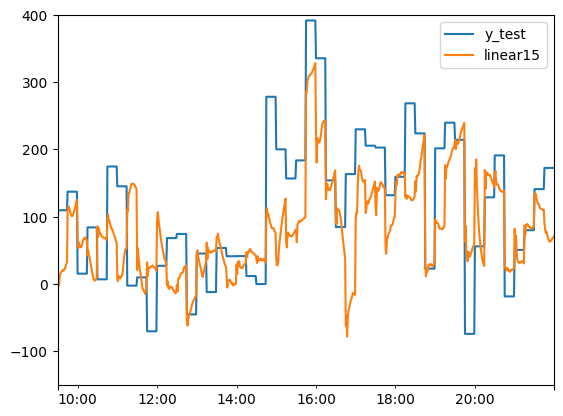

In [128]:
total_mae = mean_absolute_error(ensemble.y_test, ensemble.linear15)
total_rmse = mean_squared_error(ensemble.y_test, ensemble.linear15, squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

ensemble[["y_test", "linear15"]].tail(15*50).plot();
plt.ylim(-150, 400);

# plt.gcf().savefig("linear.png", dpi=300)

# import matplotlib.dates as mdates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# plt.gcf().autofmt_xdate()

Total MAE: 101.80MW | Total RMSE: 135.19MW


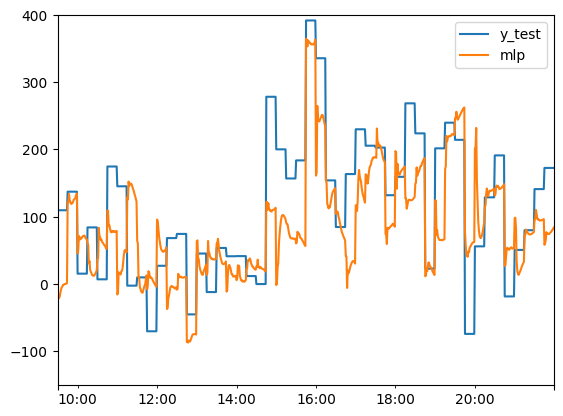

In [129]:
total_mae = mean_absolute_error(ensemble.y_test, ensemble.mlp)
total_rmse = mean_squared_error(ensemble.y_test, ensemble.mlp, squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

ensemble[["y_test", "mlp"]].tail(15*50).plot();
plt.ylim(-150, 400);

# plt.gcf().savefig("mlp.png", dpi=300)

# import matplotlib.dates as mdates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%y-%m-%d %H:%M'))
# plt.gcf().autofmt_xdate()

#### Stacking

In [154]:
ensemble = ensemble.dropna()

# Fit en ensemble stacking using 3/4 of data:
fit = Ridge(alpha=0.5, tol=1e-4,).fit(
    ensemble.drop("y_test", axis=1).iloc[:3*len(ensemble)//4, :], 
    ensemble["y_test"].iloc[:3*len(ensemble)//4]
    )
pd.DataFrame(data={"coef":fit.coef_}, index=ensemble.drop("y_test", axis=1).columns)

ensemble = ensemble.dropna()

# Fit en ensemble stacking using 3/4 of data:
fit = Ridge(alpha=1.0).fit(
    ensemble.drop("y_test", axis=1).iloc[:3*len(ensemble)//4, :], 
    ensemble["y_test"].iloc[:3*len(ensemble)//4]
    )
pd.DataFrame(data={"coef":fit.coef_}, index=ensemble.drop("y_test", axis=1).columns)

,coef
linear,-0.693862
linear15,0.949626
mlp,0.547439
forest,0.253044


In [155]:
best = fit.predict(ensemble.drop("y_test", axis=1))

total_mae = mean_absolute_error(best, ensemble["y_test"])
total_rmse = np.sqrt(mean_squared_error(best, ensemble["y_test"]))
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(100.27, 133.02)

Total MAE: 100.27MW | Total RMSE: 133.02MW
10.5% | 10.7% | 0.689


In [156]:
# Fit an ensemble stacking using all data:
fit = LinearRegression().fit(
    ensemble.drop("y_test", axis=1),
    ensemble["y_test"]
    )
pd.DataFrame(data={"coef":fit.coef_}, index=ensemble.drop("y_test", axis=1).columns)

,coef
linear,-0.667631
linear15,0.937528
mlp,0.537123
forest,0.229707


In [157]:
best = fit.predict(ensemble.drop("y_test", axis=1))

total_mae = mean_absolute_error(best, ensemble["y_test"])
total_rmse = np.sqrt(mean_squared_error(best, ensemble["y_test"]))
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

check(100.18, 133.00)

Total MAE: 100.18MW | Total RMSE: 133.00MW
10.5% | 10.7% | 0.688


---

## Predicting diff()

In [158]:
MINUTE = "all"
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [0, -1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "total_load_last_mw": {
        "lags": [-1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -2, -3, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "system_imbalance_cum15_current_qh"
FEATURES = [feature for feature in df.columns if feature != TARGET]
# FEATURES.remove("system_imbalance_cum15_from_qh_plus_1")

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 4, gap=0)

In [160]:
# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(n_jobs=-1),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

In [ ]:
qh["diff_system_imbalance_cum15"] = qh["system_imbalance_cum15"].diff()

MINUTE = "all"
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [0],
    },
    "diff_system_imbalance_cum15": {
        "lags": [0, -1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "total_load_last_mw": {
        "lags": [-1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -2, -3, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "diff_system_imbalance_cum15_current_qh"
FEATURES = [feature for feature in df.columns if feature != TARGET]
FEATURES.remove("system_imbalance_cum15_current_qh")

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 4, gap=0)

In [ ]:
# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(n_jobs=-1),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:57<00:00,  1.57it/s]



Train set average error:
MAE: 47.42MW | RMSE: 66.16MW
Test set average error:
MAE: 48.71MW | RMSE: 67.80MW | MASE: 0.2650 | P90 Error: 107.12MW | Max Error: 843.9 (2022-10-05 10:00:00+02:00)
Time elapsed: 58.00s | Time per split: ~0.64s



In [ ]:
y_pred = df["system_imbalance_cum15_current_qh"].shift(15).loc[results_linear[0].index] + results_linear[0]["y_pred"]

y_test = df["system_imbalance_cum15_current_qh"].loc[results_linear[0].index]

total_mae = mean_absolute_error(y_test, y_pred)
total_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Total MAE: 48.76MW | Total RMSE: 67.88MW


---

## Predicting diff(2)

In [ ]:
qh["diff_system_imbalance_cum15"] = qh["system_imbalance_cum15"].diff(2)

MINUTE = "all"
qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "diff_system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "total_load_last_mw": {
        "lags": [-1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -2, -3, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "diff_system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]
FEATURES.remove("system_imbalance_cum15_from_qh_plus_1")

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 4, gap=0)

In [ ]:
# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(n_jobs=-1),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                use_scaler=True,
                                verbose=False)

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [01:10<00:00,  1.29it/s]


Train set average error:
MAE: 104.58MW | RMSE: 139.44MW
Test set average error:
MAE: 107.53MW | RMSE: 143.39MW | MASE: 0.4116 | P90 Error: 227.89MW | Max Error: 1090.3 (2022-09-06 21:15:00+02:00)
Time elapsed: 70.85s | Time per split: ~0.78s



In [ ]:
y_pred = df["system_imbalance_cum15_from_qh_plus_1"].shift(30).loc[results_linear[0].index] + results_linear[0]["y_pred"]

y_test = df["system_imbalance_cum15_from_qh_plus_1"].loc[results_linear[0].index]

total_mae = mean_absolute_error(y_test, y_pred)
total_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Total MAE: 107.57MW | Total RMSE: 143.45MW
